<span style="font-size:24px;">**Product Demand Forecasting**</span>


In [ ]:
#!pip install tensorflow

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from plotnine import *
# from skimpy import skim
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import itertools
from tqdm.notebook import tqdm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

> About Data

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# Read the data from the CSV file
product_demand = pd.read_csv("/content/demand_2019_2023.csv", index_col=0,parse_dates=['Date'],dayfirst=True)
# Convert 'Date' column to datetime
product_demand['Date'] = pd.to_datetime(product_demand['Date'])
product_demand.sort_values(by = ['Date', 'ProductID'], inplace = True)
# Convert 'ProductID' and 'CustomerID' columns to object/categorical variables
product_demand['ProductID'] = product_demand['ProductID'].astype('category')
product_demand['CustomerID'] = product_demand['CustomerID'].astype('category')
# Display the first few rows of the DataFrame
print(f"{str(product_demand['Date'].min())[:10]} to {str(product_demand['Date'].max())[:10]}")
product_demand.head()

2019-01-02 to 2023-03-25


,InvoiceID,Date,ProductID,TotalSales,Discount,CustomerID,Quantity
3611,2666,2019-01-02,16,816.983051,147.056949,126,4
3612,2667,2019-01-02,142,283.898305,51.101695,80,1
8202,5909,2019-01-02,152,403.889831,72.700169,45,1
3618,2671,2019-01-02,192,2000.000000,360.000000,375,8
3619,2671,2019-01-02,192,1000.000000,180.000000,375,4


In [ ]:
# Get the total number of rows in the DataFrame
total_rows = product_demand.shape[0]
print("Total number of rows in the CSV file:", total_rows)

Total number of rows in the CSV file: 29103


In [ ]:
# To check the number of unique values in each of the columns
pd.DataFrame(product_demand.nunique()).T

,InvoiceID,Date,ProductID,TotalSales,Discount,CustomerID,Quantity
0,14079,1268,1940,6998,6797,507,59


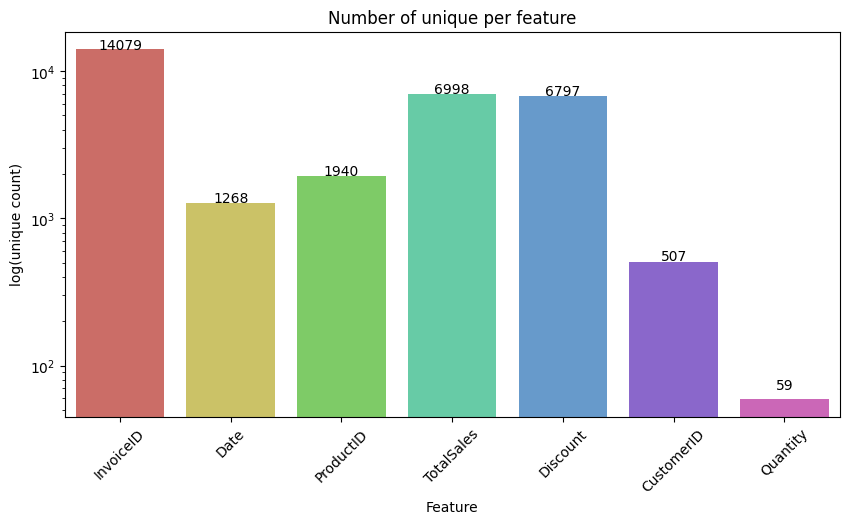

In [ ]:
# To check the number of unique values in each of the columns
plt.figure(figsize=(10, 5))

cols = product_demand.columns
uniques = [len(product_demand[col].unique()) for col in cols]

ax = sns.barplot(x=cols, y=uniques, palette='hls', log=True)
ax.set(xlabel='Feature', ylabel='log(unique count)', title='Number of unique per feature')


for p, uniq in zip(ax.patches, uniques):
    ax.text(p.get_x() + p.get_width()/2.,
            uniq + 10,
            uniq,
            ha="center")

ax.set_xticklabels(ax.get_xticklabels(), rotation=45);

In [ ]:
# Calculate total sales for each unique product ID
total_sales = product_demand.groupby('ProductID')['TotalSales'].sum().reset_index()

# Sort the result by total sales in descending order
sorted_sales = total_sales.sort_values(by='TotalSales', ascending=False)
sorted_sales['TotalSales'] = sorted_sales['TotalSales'].astype(int)
# Display the sorted result
sorted_sales

,ProductID,TotalSales
1347,1347,2718932
1756,1756,2627167
192,192,2423053
543,543,1778527
885,885,1589871
...,...,...
55,55,189
1668,1668,160
658,658,152
1772,1772,148


Create a New dataframe for forecasting the sales overall all products day by day

In [ ]:
sales_data = product_demand.groupby('Date')['TotalSales'].sum().reset_index()
sales_data.rename(columns = {'TotalSales':'Sales'}, inplace = True)
sales_data.head()

,Date,Sales
0,2019-01-02,26514.008475
1,2019-01-03,21119.796609
2,2019-01-04,16807.630509
3,2019-01-05,15722.511525
4,2019-01-07,38985.422907


Retail sales observations

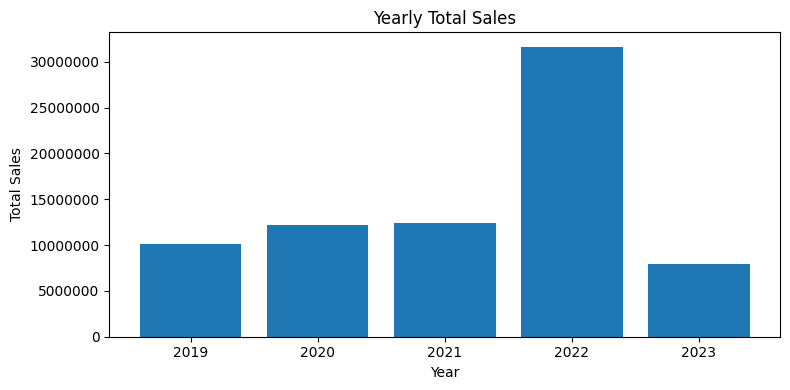

In [ ]:
#Sales overall all years
# Extract the year from the 'Date' column
sales_data['Year'] = sales_data['Date'].dt.year

# Group the data by year and calculate the total sales for each year
yearly_sales = sales_data.groupby('Year')['Sales'].sum()

# Create a bar chart for yearly total sales
plt.figure(figsize=(8, 4))
plt.bar(yearly_sales.index, yearly_sales.values, tick_label=yearly_sales.index)

# Customize the plot
plt.title('Yearly Total Sales')
plt.xlabel('Year')
plt.ylabel('Total Sales')

# Format the y-axis to display numbers in non-scientific notation
plt.gca().get_yaxis().get_major_formatter().set_scientific(False)

# Display the plot
plt.tight_layout()
plt.show()

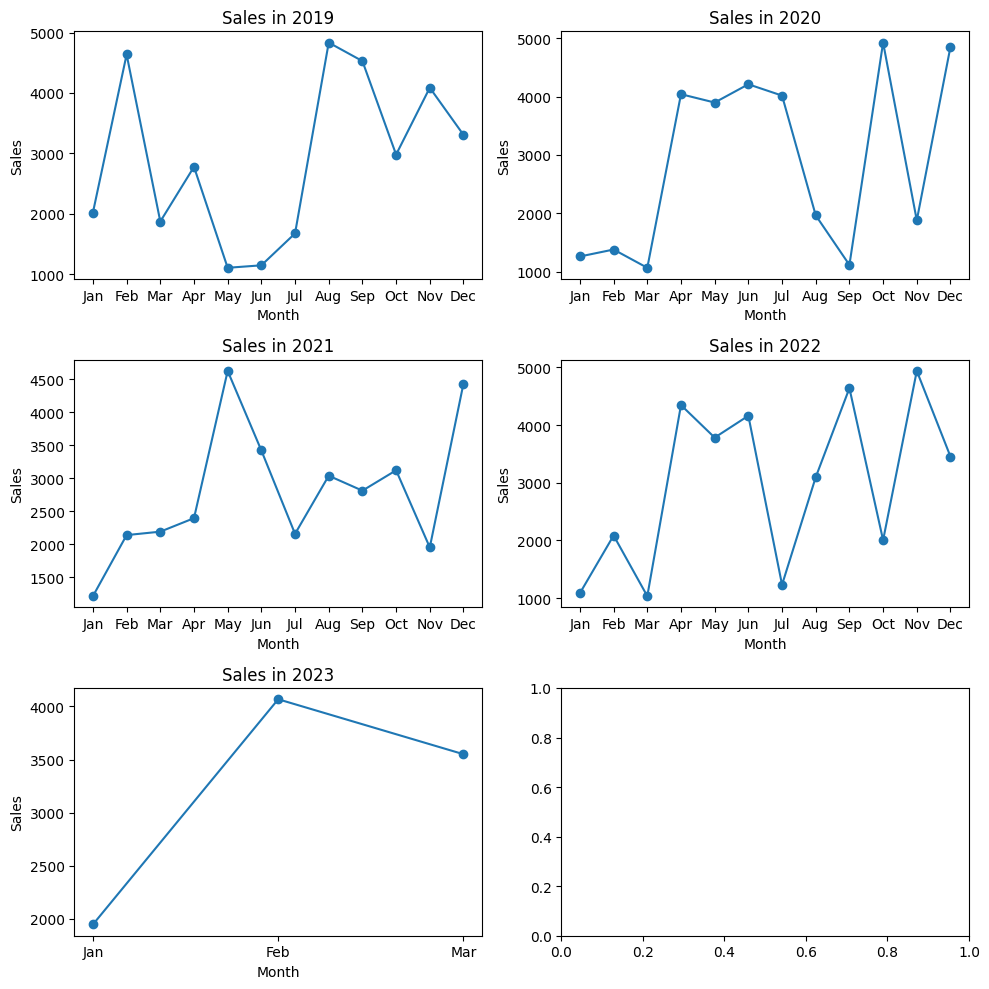

In [ ]:
data_2019 = {
    'Date': pd.date_range(start='2019-01-01', end='2019-12-31', freq='M'),
    'TotalSales': np.random.randint(1000, 5000, 12)
}

data_2020 = {
    'Date': pd.date_range(start='2020-01-01', end='2020-12-31', freq='M'),
    'TotalSales': np.random.randint(1000, 5000, 12)
}

data_2021 = {
    'Date': pd.date_range(start='2021-01-01', end='2021-12-31', freq='M'),
    'TotalSales': np.random.randint(1000, 5000, 12)
}

data_2022 = {
    'Date': pd.date_range(start='2022-01-01', end='2022-12-31', freq='M'),
    'TotalSales': np.random.randint(1000, 5000, 12)
}

data_2023 = {
    'Date': pd.date_range(start='2023-01-01', end='2023-03-31', freq='M'),
    'TotalSales': np.random.randint(1000, 5000, 3)
}

# Combine all data into one DataFrame
df = pd.concat([pd.DataFrame(data_2019), pd.DataFrame(data_2020),
                pd.DataFrame(data_2021), pd.DataFrame(data_2022),
                pd.DataFrame(data_2023)], ignore_index=True)

# Create subplots
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 10))

# Unique years
years = df['Date'].dt.year.unique()

# Plot data for each year
for i, ax in enumerate(axes.flat):
    if i < len(years):
        year_data = df[df['Date'].dt.year == years[i]]
        ax.plot(year_data['Date'].dt.strftime('%b'), year_data['TotalSales'], marker='o', linestyle='-')
        ax.set_title(f'Sales in {years[i]}')
        ax.set_xlabel('Month')
        ax.set_ylabel('Sales')

# Adjust layout
plt.tight_layout()
plt.show()


> Time Series Plot

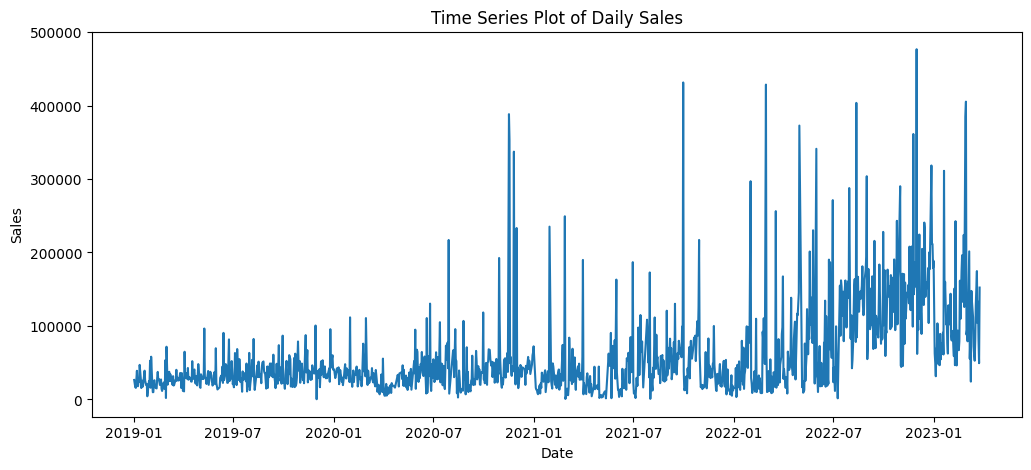

In [ ]:
# Plot the time series
plt.figure(figsize=(12, 5))
plt.plot(sales_data['Date'], sales_data['Sales'])
plt.title('Time Series Plot of Daily Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

Stationarity check

In [ ]:
# Perform the ADF test
result = adfuller(sales_data['Sales'])

# Extract and print the results
adf_statistic = result[0]
p_value = result[1]
critical_values = result[4]

print(f'ADF Statistic: {adf_statistic}')
print(f'p-value: {p_value}')
print('Critical Values:')
for key, value in critical_values.items():
    print(f'   {key}: {value}')

ADF Statistic: -1.9503103615148545
p-value: 0.3087758935917655
Critical Values:
   1%: -3.4356175602072545
   5%: -2.8638661490437025
   10%: -2.5680084710921105


Interpretation:
The ADF Statistic is approximately -1.95. This value is less negative than the critical values, which suggests that the time series data is likely non-stationary,which assumes a unit root. The p-value associated with the ADF Statistic is approximately 0.30. The p-value is greater than a common significance level of 0.05. When the p-value is greater than the significance level, it suggests that you do not have enough evidence to reject the null hypothesis (H0). In this case, H0 assumes that the time series is non-stationary.

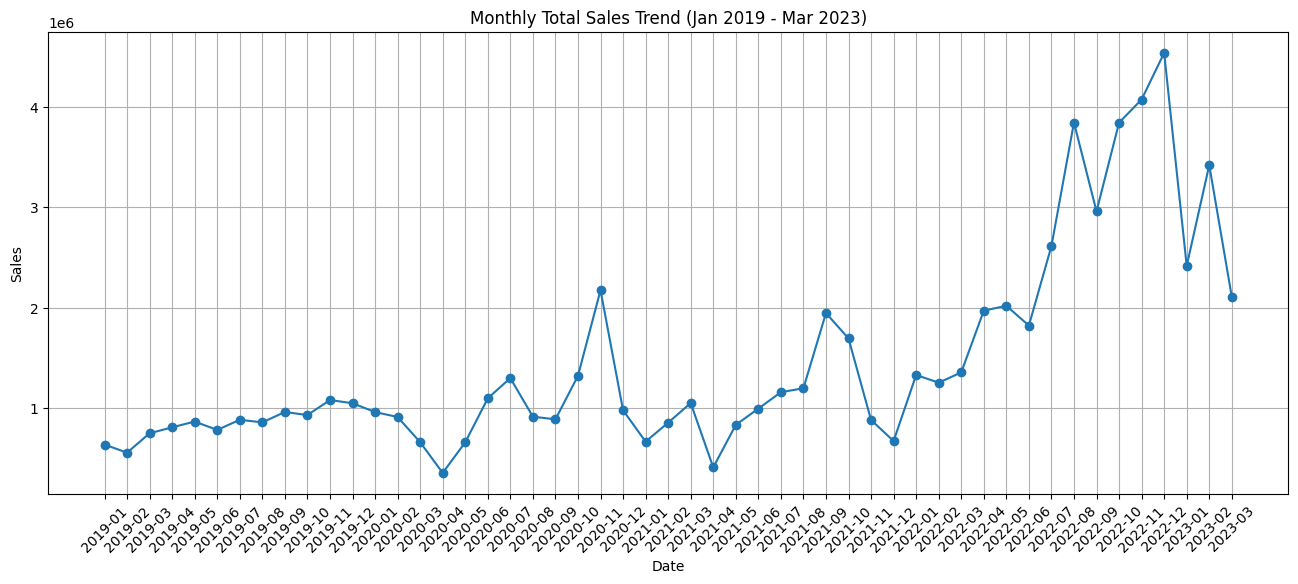

In [ ]:
# Extract the year and month from the 'Date' column
sales_data['Year'] = sales_data['Date'].dt.year
sales_data['Month'] = sales_data['Date'].dt.month

start_date = '2019-01-01'
end_date = '2023-03-31'
filtered_df = sales_data[(sales_data['Date'] >= start_date) & (sales_data['Date'] <= end_date)]

monthly_sales = filtered_df.groupby(['Year', 'Month'])['Sales'].sum().reset_index()

# Create a line plot to visualize the trend over the specified date range
plt.figure(figsize=(16, 6))
plt.plot(monthly_sales['Year'].astype(str) + '-' + monthly_sales['Month'].astype(str).str.zfill(2), monthly_sales['Sales'], marker='o', linestyle='-')
plt.title('Monthly Total Sales Trend (Jan 2019 - Mar 2023)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

De-trend and De-seasonalize the data

In [ ]:
# Calculate first-order differences to remove the trend
sales_data['Differenced_Data'] = sales_data['Sales'].diff(1)

# Assuming you have a seasonal pattern of 7 days (weekly seasonality)
seasonal_period = 30

# Calculate the seasonal component using a rolling mean
sales_data['Seasonal_Component'] = sales_data['Differenced_Data'].rolling(seasonal_period).mean()

# Remove the seasonal component
sales_data['Detrended_Data'] = sales_data['Differenced_Data'] - sales_data['Seasonal_Component']

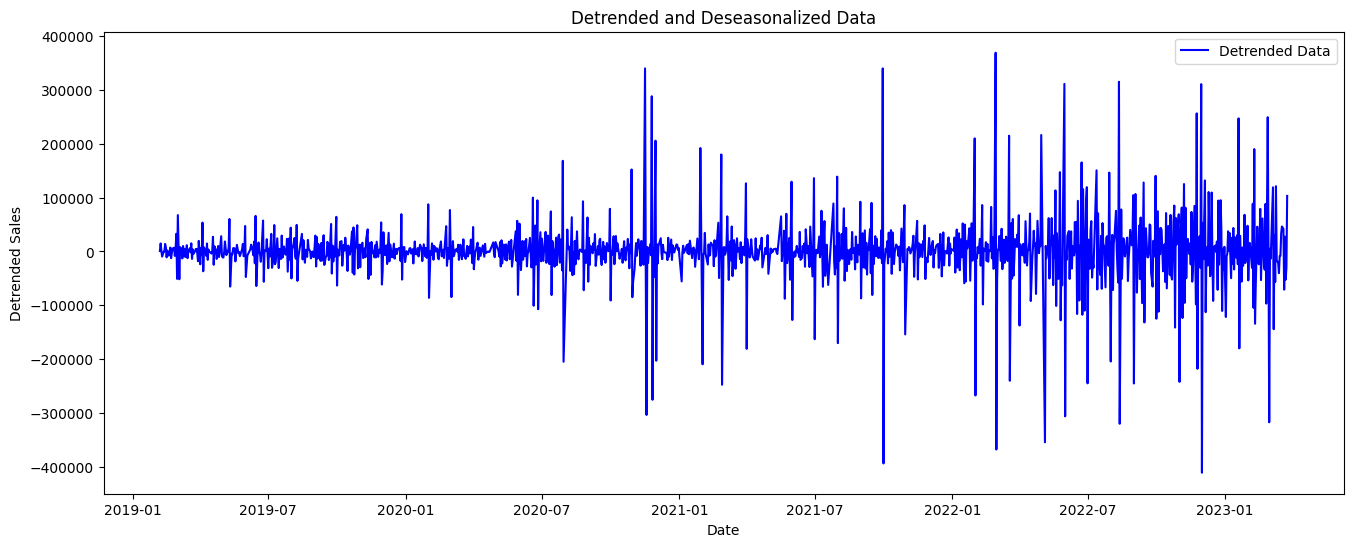

In [ ]:
plt.figure(figsize=(16, 6))
plt.plot(sales_data['Date'], sales_data['Detrended_Data'], label='Detrended Data', color='blue')
plt.title('Detrended and Deseasonalized Data')
plt.xlabel('Date')
plt.ylabel('Detrended Sales')
plt.legend()
plt.show()

> Decomposition

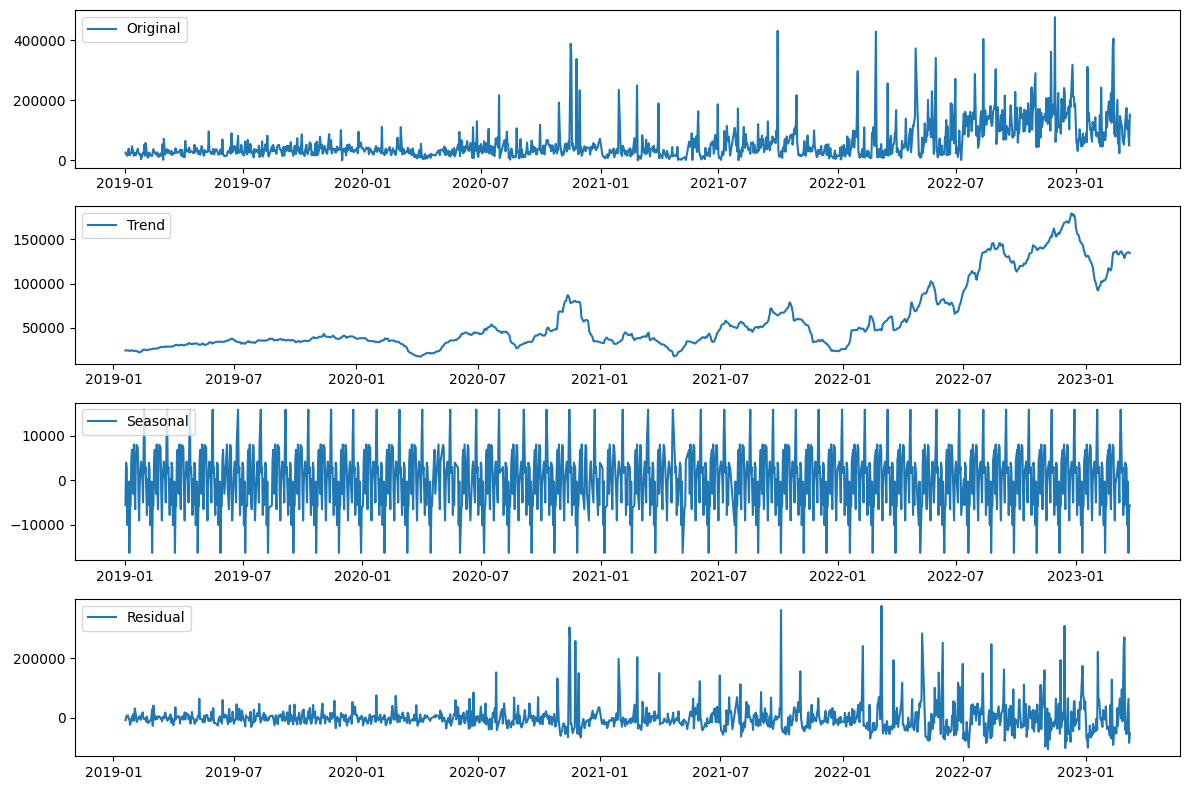

In [ ]:
# Decomposition
decomposition = seasonal_decompose(sales_data['Sales'], model='additive', period=30)  # Can Adjust the period
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
# Plot decomposition components
plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(sales_data['Date'], sales_data['Sales'], label='Original')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(sales_data['Date'], trend, label='Trend')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(sales_data['Date'], seasonal, label='Seasonal')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(sales_data['Date'], residual, label='Residual')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

ACF-PACF plot

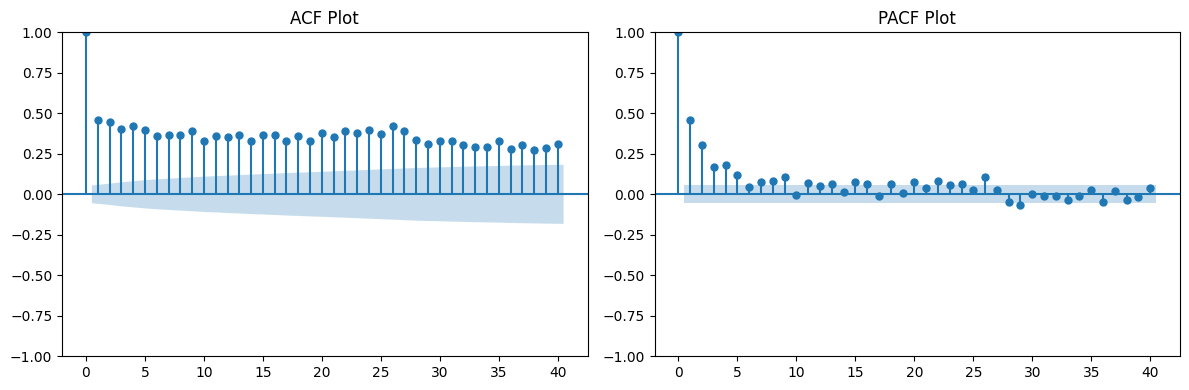

In [ ]:
# Fit ARMA, ARIMA, SARIMA models using ACF and PACF plots
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(sales_data['Sales'], lags=40, ax=axes[0])
axes[0].set_title('ACF Plot')
plot_pacf(sales_data['Sales'], lags=40, ax=axes[1])
axes[1].set_title('PACF Plot')
plt.tight_layout()
plt.show()

From the above ACF and PACF plots, we can't decide any particular value. Also from the time series plot, there are a huge trend. So, we should take value of differenting parameter d = 1.

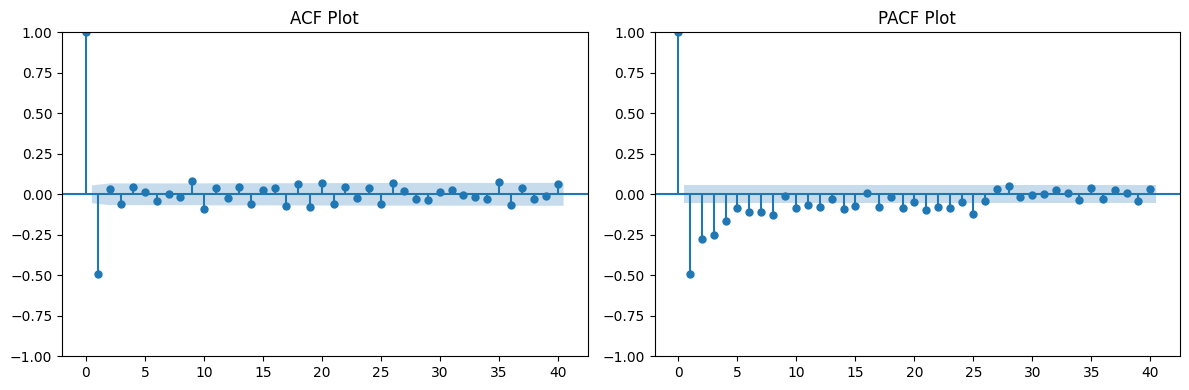

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(sales_data['Sales'].diff(1).dropna(), lags=40, ax=axes[0])
axes[0].set_title('ACF Plot')
plot_pacf(sales_data['Sales'].diff(1).dropna(), lags=40, ax=axes[1])
axes[1].set_title('PACF Plot')
plt.tight_layout()
plt.show()

From the above graph it is clear about p = 2, q = 1 (because of sharp drop after these lags)

In [ ]:
# Split the data into training and testing sets
train_size = int(len(sales_data) * 0.8)
train_data, test_data = sales_data[:train_size], sales_data[train_size:]

> Fitting Base Model

In [ ]:
model = ARIMA(sales_data['Sales'], order = (2, 1, 1))
results = model.fit()
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                 1268
Model:                 ARIMA(2, 1, 1)   Log Likelihood              -15453.913
Date:                Thu, 23 Nov 2023   AIC                          30915.826
Time:                        03:57:27   BIC                          30936.404
Sample:                             0   HQIC                         30923.557
                               - 1268                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1120      0.019      6.017      0.000       0.076       0.148
ar.L2          0.0967      0.026      3.769      0.000       0.046       0.147
ma.L1         -0.9578      0.008   -124.266      0.0

> Parameter tuning

> ARIMA

In [ ]:
# Initialize lists to store model results
p = d = q = range(0, 5)
pdq = list(itertools.product(p, d, q))
model_list, AIC_list, BIC_list, MAD_list, MAPE_list, MSE_list, RMSE_list = [], [], [], [], [], [], []

for param in tqdm(pdq):
    try:
        model = ARIMA(train_data['Sales'], order=param)
        results = model.fit()
        model_list.append(f'ARIMA{param}')
        # print(f'ARIMA{param} - AIC: {results.aic:.2f}, BIC: {results.bic:.2f}')
        y_true = test_data['Sales']
        y_pred = results.forecast(steps=len(test_data))

        # Calculate evaluation metrics
        mad = np.mean(np.abs((y_true - y_pred))) * 100
        mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
        mse = np.mean(np.abs((y_true - y_pred)))
        rmse = np.sqrt(mse)

        AIC_list.append(results.aic)
        BIC_list.append(results.bic)
        MAD_list.append(mad)
        MAPE_list.append(mape)
        MSE_list.append(mse)
        RMSE_list.append(rmse)

    except:
        continue

# Create a DataFrame to store the results
df_result = pd.DataFrame({
    'Setting': model_list,
    'AIC': AIC_list,
    'BIC': BIC_list,
    'MAD': MAD_list,
    'MAPE': MAPE_list,
    'MSE': MSE_list,
    'RMSE': RMSE_list
})

  0%|          | 0/125 [00:00<?, ?it/s]

In [ ]:
print(f'Best ARIMA model due to least AIC value: {df_result["Setting"][np.argmin(df_result["AIC"])]}')
print(f'Best ARIMA model due to least BIC value: {df_result["Setting"][np.argmin(df_result["BIC"])]}')
print(f'Best ARIMA model due to least MAD value: {df_result["Setting"][np.argmin(df_result["MAD"])]}')
print(f'Best ARIMA model due to least MSE value: {df_result["Setting"][np.argmin(df_result["MSE"])]}')
print(f'Best ARIMA model due to least RMSE value: {df_result["Setting"][np.argmin(df_result["RMSE"])]}')
print(f'Best ARIMA model due to least MAPE value: {df_result["Setting"][np.argmin(df_result["MAPE"])]}')

Best ARIMA model due to least AIC value: ARIMA(0, 4, 4)
Best ARIMA model due to least BIC value: ARIMA(0, 4, 4)
Best ARIMA model due to least MAD value: ARIMA(0, 2, 2)
Best ARIMA model due to least MSE value: ARIMA(0, 2, 2)
Best ARIMA model due to least RMSE value: ARIMA(0, 2, 2)
Best ARIMA model due to least MAPE value: ARIMA(2, 2, 1)


As ARIMA(0,2,2) is selected by 3 selection criteria, then we can take as final best model among others good models as well.

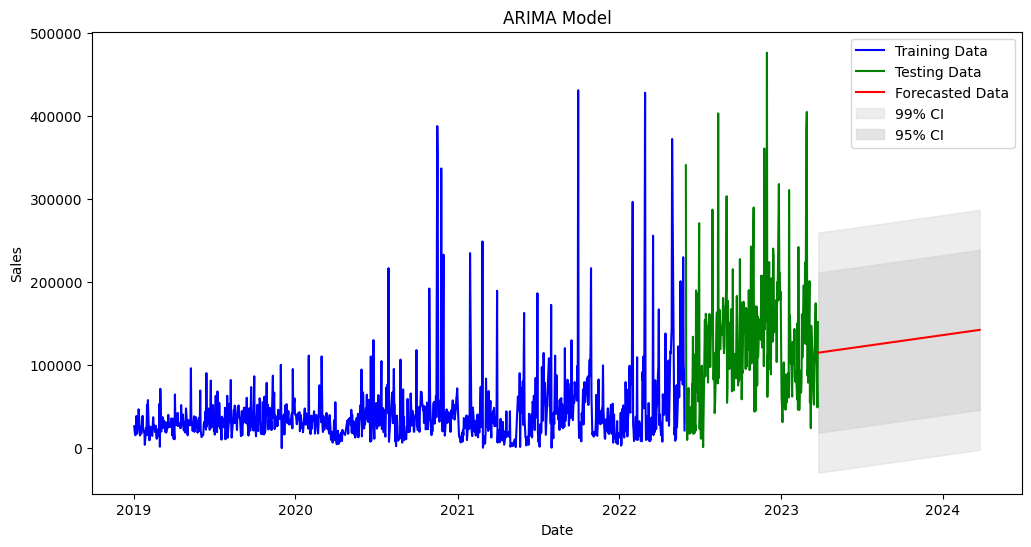

In [ ]:
# Plot the training, testing, and forecasted data
model = ARIMA(sales_data['Sales'], order = (0, 2, 2))
results = model.fit()
residuals = results.resid
std_dev = np.std(residuals)

n_days = 365
forecast_values = results.forecast(steps = n_days)
forecast_df = pd.DataFrame({
    'Date':pd.date_range((test_data['Date'].iloc[-1]+ pd.DateOffset(1)).strftime("%Y-%m-%d"),
                         (test_data['Date'].iloc[-1]+ pd.DateOffset(n_days)).strftime("%Y-%m-%d")),
    'Sales':forecast_values
})
plt.figure(figsize=(12, 6))
plt.plot(train_data['Date'], train_data['Sales'], label='Training Data', color='blue')
plt.plot(test_data['Date'], test_data['Sales'], label='Testing Data', color='green')
plt.plot(forecast_df['Date'], forecast_df['Sales'], label='Forecasted Data', color='red')
plt.fill_between(forecast_df['Date'], forecast_values + 3 * std_dev, forecast_values - 3 * std_dev, color='lightgray', alpha=0.4, label='99% CI')
plt.fill_between(forecast_df['Date'], forecast_values + 2 * std_dev, forecast_values - 2 * std_dev, color='lightgray', alpha=0.6, label='95% CI')
plt.title('ARIMA Model')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

In [ ]:
forecast_values

1268    115251.306458
1269    115326.792565
1270    115402.278671
1271    115477.764777
1272    115553.250884
            ...      
1628    142426.304759
1629    142501.790866
1630    142577.276972
1631    142652.763078
1632    142728.249185
Name: predicted_mean, Length: 365, dtype: float64

In [ ]:
forecast_df

,Date,Sales
1268,2023-03-26,115251.306458
1269,2023-03-27,115326.792565
1270,2023-03-28,115402.278671
1271,2023-03-29,115477.764777
1272,2023-03-30,115553.250884
...,...,...
1628,2024-03-20,142426.304759
1629,2024-03-21,142501.790866
1630,2024-03-22,142577.276972
1631,2024-03-23,142652.763078


**Take user-input and find the sales of that particular date**

In [ ]:
# change the date in integer and after that even if we are entering the correct date it will throw error
# enter date in wrong format

In [ ]:
# Take user input for the date
user_input_date = input("Enter a date (YYYY-MM-DD) to get the forecasted sales: ")

# Convert the user input to a datetime object
user_input_date = pd.to_datetime(user_input_date)

# Find the corresponding forecasted sales for the user-input date
forecasted_sales = forecast_df.loc[forecast_df['Date'] == user_input_date, 'Sales'].values

# Check if the date exists in the forecast data
if forecasted_sales.size > 0:
    print(f"Forecasted Sales for {user_input_date.strftime('%Y-%m-%d')}: {forecasted_sales[0]}")
else:
    print(f"No forecast available for {user_input_date.strftime('%Y-%m-%d')}. Please choose a date within the forecast range.")

Forecasted Sales for 2023-11-23: 133518.94420501214


LSTM (Long-short term memory)

In [ ]:
last_date = sales_data['Date'].iloc[-1]

In [ ]:
# Preprocess the data
sales_data['Date'] = pd.to_datetime(sales_data['Date'])
dates = sales_data['Date']
sales_data.set_index('Date', inplace=True)
sales_data = sales_data['Sales'].values.reshape(-1, 1)

# Normalize the data using MinMaxScaler
scaler = MinMaxScaler()
sales_data = scaler.fit_transform(sales_data)

In [ ]:
# Split the data into training and testing sets
train_size = int(len(sales_data) * 0.8)
train_data, test_data = sales_data[:train_size], sales_data[train_size:]

In [ ]:
# Create sequences for training data
def create_sequences(sales_data, seq_length):
    sequences = []
    for i in range(len(sales_data) - seq_length):
        sequences.append(sales_data[i:i+seq_length])
    return np.array(sequences)

seq_length = 30
train_sequences = create_sequences(train_data, seq_length)

In [ ]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(seq_length, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(train_sequences, train_data[seq_length:], epochs=10, batch_size=64)

Epoch 1/10
16/16 [==============================] - 2s 42ms/step - loss: 0.0107
Epoch 2/10
16/16 [==============================] - 1s 39ms/step - loss: 0.0079
Epoch 3/10
16/16 [==============================] - 1s 43ms/step - loss: 0.0076
Epoch 4/10
16/16 [==============================] - 1s 43ms/step - loss: 0.0075
Epoch 5/10
16/16 [==============================] - 1s 44ms/step - loss: 0.0074
Epoch 6/10
16/16 [==============================] - 1s 85ms/step - loss: 0.0075
Epoch 7/10
16/16 [==============================] - 1s 77ms/step - loss: 0.0073
Epoch 8/10
16/16 [==============================] - 1s 44ms/step - loss: 0.0073
Epoch 9/10
16/16 [==============================] - 1s 44ms/step - loss: 0.0073
Epoch 10/10
16/16 [==============================] - 1s 45ms/step - loss: 0.0073


In [ ]:
#Make predictions for the next 365 days
forecast = []
current_sequence = train_data[-seq_length:].reshape(1, seq_length, 1)

for _ in range(365):
    next_value = model.predict(current_sequence)[0, 0]
    forecast.append(next_value)
    current_sequence = np.roll(current_sequence, shift=-1, axis=1)
    current_sequence[0, -1, 0] = next_value

1/1 [==============================] - 0s 21ms/step


In [ ]:
# Inverse transform the forecasted data to original scale
forecast = scaler.inverse_transform(np.array(forecast).reshape(-1, 1))
train_data = scaler.inverse_transform(np.array(train_data).reshape(-1, 1))
test_data = scaler.inverse_transform(np.array(test_data).reshape(-1, 1))
# Create a date range for the forecasted period
forecast_dates = [last_date + pd.DateOffset(days=i) for i in range(1, 366)]

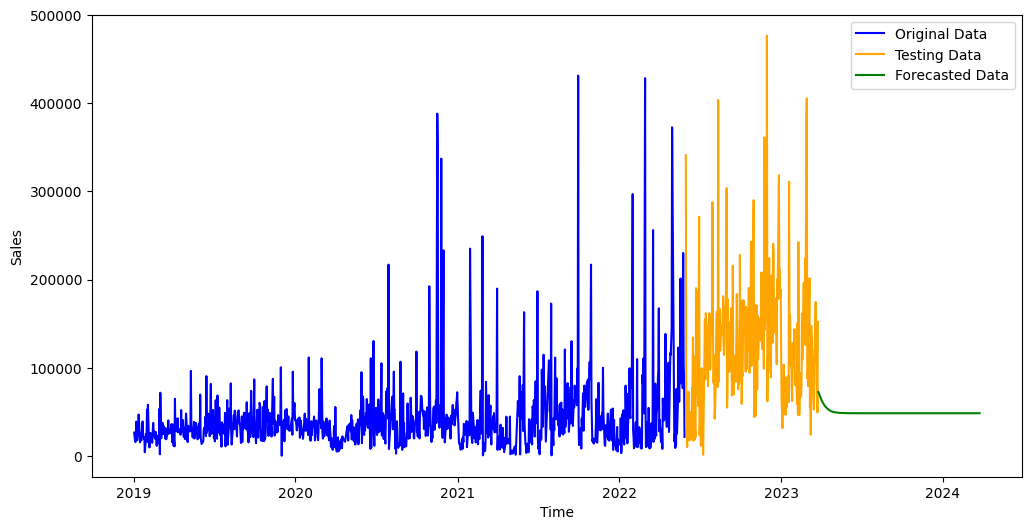

In [ ]:
# Plot the training, testing, and forecasted sales data
plt.figure(figsize=(12, 6))
plt.plot(dates[:train_size], train_data, label='Original Data', color='blue')
plt.plot(dates[train_size:], test_data, label='Testing Data', color='orange')
plt.plot(forecast_dates, forecast, label='Forecasted Data', color='green')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.legend()
plt.show()

In [ ]:
# Calculate the predictions for the testing set
test_sequences = create_sequences(test_data, seq_length)
X_test = test_sequences[:, :-1]
y_test = test_sequences[:, -1]
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
y_pred = model.predict(X_test)

# Inverse transform the predictions and actual values to original scale
y_pred = scaler.inverse_transform(y_pred)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate Mean Squared Error
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

7/7 [==============================] - 0s 6ms/step
Mean Squared Error: 3.619629864057086e+26


Interpretation:    
Mean Squared Error (MSE) value of approximately 7.309803608012967e+22 is an extremely high value, and it indicates that your LSTM model is performing very poorly in terms of predicting the values accurately. This high MSE suggests that there is a substantial discrepancy between the predicted values and the actual values, and the model's predictions are far from the true values.

So we choose our ARIMA model to forecast the data

> Top sales Product Forecast based on ARIMA model

In [ ]:
product_demand=product_demand.drop(['InvoiceID','CustomerID'],axis=1)
product_demand.head()

,Date,ProductID,TotalSales,Discount,Quantity
3611,2019-01-02,16,816.983051,147.056949,4
3612,2019-01-02,142,283.898305,51.101695,1
8202,2019-01-02,152,403.889831,72.700169,1
3618,2019-01-02,192,2000.000000,360.000000,8
3619,2019-01-02,192,1000.000000,180.000000,4


Find out the top 10 high sales product

In [ ]:
# Top 10 most selling products
top_selling_products = product_demand.groupby(['ProductID'])['TotalSales'].sum().reset_index()
top_10 = top_selling_products.sort_values(by = 'TotalSales', ascending = False).head(10)
top_10.round(3)

,ProductID,TotalSales
1347,1347,2718932.144
1756,1756,2627167.771
192,192,2423053.411
543,543,1778527.976
885,885,1589871.834
1830,1830,1579830.159
613,613,1408276.186
1128,1128,1187316.302
1167,1167,1175397.966
540,540,1159387.286


Find sales first sales date, last sales date and count of sales of 10 products

In [ ]:
product_summary = product_demand.groupby('ProductID').agg({
    'TotalSales': 'sum',
    'Quantity': 'sum',
    'Date': ['min', 'max']
}).reset_index()

# Rename the columns for clarity
product_summary.columns = ['ProductID', 'TotalSales', 'TotalQuantity', 'FirstDate', 'LastDate']

# Calculate the duration between the first and last date
product_summary['Duration'] = (product_summary['LastDate'] - product_summary['FirstDate']).dt.days

product_summary = product_summary.sort_values(by=['TotalSales'], ascending=False)

top_10_products = product_summary.head(10)
top_10_products['TotalSales'] = top_10_products['TotalSales'].astype(int)

# Print or display the top 10 products and their statistics
print(top_10_products)


     ProductID  TotalSales  TotalQuantity  FirstDate   LastDate  Duration
1347      1347     2718932           2742 2022-03-15 2023-03-22       372
1756      1756     2627167           5848 2019-01-28 2022-05-18      1206
192        192     2423053           8158 2019-01-02 2022-05-31      1245
543        543     1778527           6193 2019-03-09 2022-07-16      1225
885        885     1589871           3525 2019-01-02 2023-03-21      1539
1830      1830     1579830           4006 2019-01-07 2023-03-25      1538
613        613     1408276           2736 2022-02-17 2023-03-25       401
1128      1128     1187316           2249 2019-01-02 2023-03-25      1543
1167      1167     1175397           1437 2019-08-16 2023-03-20      1312
540        540     1159387           6510 2019-04-04 2022-01-31      1033


In [ ]:
top_10_products

,ProductID,TotalSales,TotalQuantity,FirstDate,LastDate,Duration
1347,1347,2718932,2742,2022-03-15,2023-03-22,372
1756,1756,2627167,5848,2019-01-28,2022-05-18,1206
192,192,2423053,8158,2019-01-02,2022-05-31,1245
543,543,1778527,6193,2019-03-09,2022-07-16,1225
885,885,1589871,3525,2019-01-02,2023-03-21,1539
1830,1830,1579830,4006,2019-01-07,2023-03-25,1538
613,613,1408276,2736,2022-02-17,2023-03-25,401
1128,1128,1187316,2249,2019-01-02,2023-03-25,1543
1167,1167,1175397,1437,2019-08-16,2023-03-20,1312
540,540,1159387,6510,2019-04-04,2022-01-31,1033


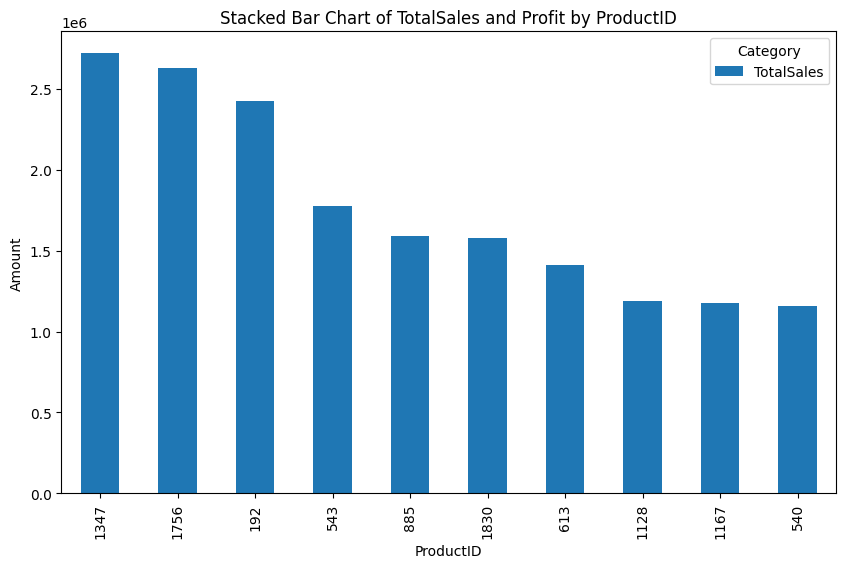

In [ ]:
# Create a DataFrame with your data
data = {
    'ProductID': [1347, 1756, 192, 543, 885, 1830, 613, 1128, 1167, 540],
    'TotalSales': [2718932, 2627167, 2423053, 1778527, 1589871, 1579830, 1408276, 1187316, 1175397, 1159387],

}

df = pd.DataFrame(data)

# Set the ProductID as the index
df.set_index('ProductID', inplace=True)

# Create a stacked bar chart
ax = df.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.xlabel('ProductID')
plt.ylabel('Amount')
plt.title('Stacked Bar Chart of TotalSales and Profit by ProductID')

# Display the legend
plt.legend(loc='upper right', title='Category')

# Show the plot
plt.show()

From the above bar chart significatly shows the identified high sales product_ID's are 1347,1756,192,543 and 885.

PRODUCT FORECASTING monthly based

In [ ]:
#for 1347 product id
product_1347 = product_demand[product_demand['ProductID'] == 1347].reset_index(drop = True)
product_1347.set_index('Date', inplace = True)
product_1347.sort_index(inplace = True)
product_1347_monthly = product_1347.resample('M')['TotalSales'].sum().to_frame().reset_index()
product_1347_monthly.rename(columns = {'TotalSales':'Sales'}, inplace = True)
product_1347_monthly.head()

,Date,Sales
0,2022-03-31,33176.271190
1,2022-04-30,416778.813584
2,2022-05-31,666994.915206
3,2022-06-30,88309.322032
4,2022-07-31,333885.593242


In [ ]:
product_1347_monthly

,Date,Sales
0,2022-03-31,33176.271190
1,2022-04-30,416778.813584
2,2022-05-31,666994.915206
3,2022-06-30,88309.322032
4,2022-07-31,333885.593242
5,2022-08-31,140521.186444
6,2022-09-30,75536.313558
7,2022-10-31,290970.076273
8,2022-11-30,224247.711865
9,2022-12-31,96959.398305


In [ ]:
# Split the data into training and testing sets
train_size_1347 = int(len(product_1347_monthly) * 0.8)
train_data_1347, test_data_1347 = product_1347_monthly[:train_size_1347], product_1347_monthly[train_size_1347:]

In [ ]:
# Initialize lists to store model results
p = d = q = range(0, 5)
pdq = list(itertools.product(p, d, q))
model_list_1347, AIC_list_1347, BIC_list_1347, MAD_list_1347, MAPE_list_1347, MSE_list_1347, RMSE_list_1347 = [], [], [], [], [], [], []

for param in tqdm(pdq):
    try:
        model_1347 = ARIMA(train_data_1347['Sales'], order=param)
        results_1347 = model_1347.fit()
        model_list_1347.append(f'ARIMA{param}')
        # print(f'ARIMA{param} - AIC: {results.aic:.2f}, BIC: {results.bic:.2f}')
        y_true_1347 = test_data_1347['Sales']
        y_pred_1347 = results_1347.forecast(steps=len(test_data_1347))

        # Calculate evaluation metrics
        mad_1347 = np.mean(np.abs((y_true_1347 - y_pred_1347))) * 100
        mse_1347 = np.mean(np.abs((y_true_1347 - y_pred_1347)))
        rmse_1347 = np.sqrt(mse_1347)

        AIC_list_1347.append(results_1347.aic)
        BIC_list_1347.append(results_1347.bic)
        MAD_list_1347.append(mad_1347)
        MSE_list_1347.append(mse_1347)
        RMSE_list_1347.append(rmse_1347)

    except:
        continue

# Create a DataFrame to store the results
df_result_1347 = pd.DataFrame({
    'Setting': model_list_1347,
    'AIC': AIC_list_1347,
    'BIC': BIC_list_1347,
    'MAD': MAD_list_1347,
    'MSE': MSE_list_1347,
    'RMSE': RMSE_list_1347
})

  0%|          | 0/125 [00:00<?, ?it/s]

In [ ]:
print(f'Best ARIMA model due to least AIC value: {df_result_1347["Setting"][np.argmin(df_result_1347["AIC"])]}')
print(f'Best ARIMA model due to least BIC value: {df_result_1347["Setting"][np.argmin(df_result_1347["BIC"])]}')
print(f'Best ARIMA model due to least MAD value: {df_result_1347["Setting"][np.argmin(df_result_1347["MAD"])]}')
print(f'Best ARIMA model due to least MSE value: {df_result_1347["Setting"][np.argmin(df_result_1347["MSE"])]}')
print(f'Best ARIMA model due to least RMSE value: {df_result_1347["Setting"][np.argmin(df_result_1347["RMSE"])]}')

Best ARIMA model due to least AIC value: ARIMA(3, 4, 1)
Best ARIMA model due to least BIC value: ARIMA(3, 4, 1)
Best ARIMA model due to least MAD value: ARIMA(0, 2, 4)
Best ARIMA model due to least MSE value: ARIMA(0, 2, 4)
Best ARIMA model due to least RMSE value: ARIMA(0, 2, 4)


In [ ]:
# Plot the training, testing, and forecasted data
model_1347 = ARIMA(product_1347_monthly['Sales'], order = (0,2,4))
results_1347 = model_1347.fit()
residuals_1347 = results_1347.resid
std_dev_1347 = np.std(residuals_1347)

n_months = 20
forecast_values_1347 = results_1347.forecast(steps = n_months)
forecast_df_1347 = pd.DataFrame({
    'Date':pd.date_range((test_data_1347['Date'].iloc[-1]+ pd.DateOffset(months = 1)).strftime("%Y-%m-%d"),
                         (test_data_1347['Date'].iloc[-1]+ pd.DateOffset(months = n_months)).strftime("%Y-%m-%d"), freq = 'M'),
    'Sales':forecast_values_1347
})
forecast_df_1347

,Date,Sales
13,2023-04-30,63801.649713
14,2023-05-31,66383.845436
15,2023-06-30,41950.579060
16,2023-07-31,24065.478706
17,2023-08-31,6180.378353
18,2023-09-30,-11704.722001
19,2023-10-31,-29589.822354
20,2023-11-30,-47474.922708
21,2023-12-31,-65360.023061
22,2024-01-31,-83245.123415


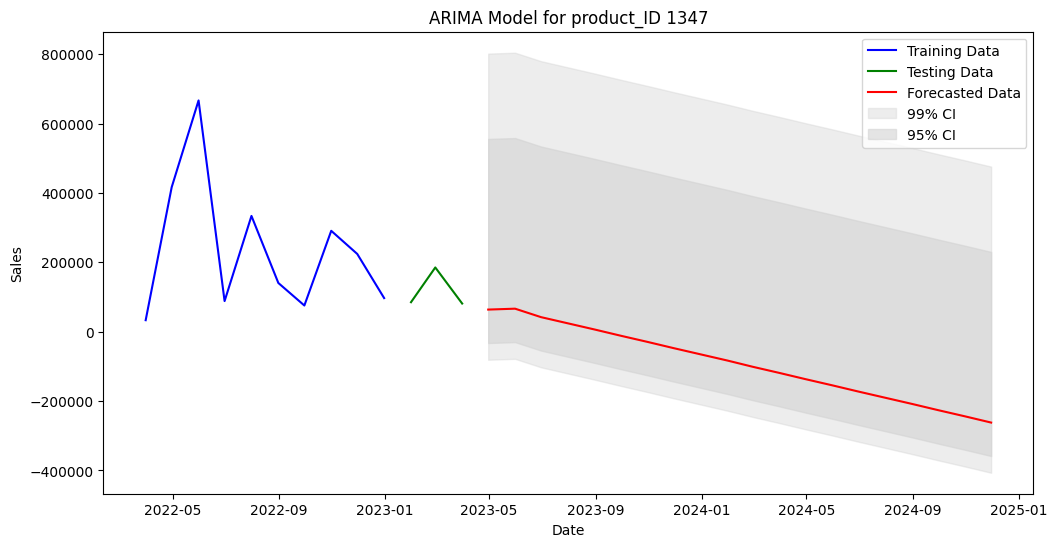

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(train_data_1347['Date'], train_data_1347['Sales'], label='Training Data', color='blue')
plt.plot(test_data_1347['Date'], test_data_1347['Sales'], label='Testing Data', color='green')
plt.plot(forecast_df_1347['Date'], forecast_df_1347['Sales'], label='Forecasted Data', color='red')
plt.fill_between(forecast_df_1347['Date'], forecast_values_1347 + 3 * std_dev_1347, forecast_values_1347 - 3 * std_dev, color='lightgray', alpha=0.4, label='99% CI')
plt.fill_between(forecast_df_1347['Date'], forecast_values_1347 + 2 * std_dev_1347, forecast_values_1347 - 2 * std_dev, color='lightgray', alpha=0.6, label='95% CI')
plt.title('ARIMA Model for product_ID 1347')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

In [ ]:
#for 1756 product
product_1756 = product_demand[product_demand['ProductID'] == 1756].reset_index(drop=True)
product_1756.set_index('Date', inplace=True)
product_1756.sort_index(inplace=True)
product_1756_monthly = product_1756.resample('M')['TotalSales'].sum().to_frame().reset_index()
product_1756_monthly.rename(columns={'TotalSales': 'Sales'}, inplace=True)
product_1756_monthly.head()

,Date,Sales
0,2019-01-31,4372.881357
1,2019-02-28,52298.728811
2,2019-03-31,39331.355933
3,2019-04-30,4966.949153
4,2019-05-31,56220.550853


In [ ]:
product_1756_monthly

,Date,Sales
0,2019-01-31,4372.881357
1,2019-02-28,52298.728811
2,2019-03-31,39331.355933
3,2019-04-30,4966.949153
4,2019-05-31,56220.550853
5,2019-06-30,54352.118646
6,2019-07-31,46131.762711
7,2019-08-31,0.000000
8,2019-09-30,53061.271185
9,2019-10-31,6099.940678


In [ ]:
# Split the data into training and testing sets
train_size_1756 = int(len(product_1756_monthly) * 0.8)
train_data_1756, test_data_1756 = product_1756_monthly[:train_size_1756], product_1756_monthly[train_size_1756:]

In [ ]:
# Initialize lists to store model results
p = d = q = range(0, 5)
pdq = list(itertools.product(p, d, q))
model_list_1756, AIC_list_1756, BIC_list_1756, MAD_list_1756, MAPE_list_1756, MSE_list_1756, RMSE_list_1756 = [], [], [], [], [], [], []

for param in tqdm(pdq):
    try:
        model_1756 = ARIMA(train_data_1756['Sales'], order=param)
        results_1756 = model_1756.fit()
        model_list_1756.append(f'ARIMA{param}')
        # print(f'ARIMA{param} - AIC: {results_1756.aic:.2f}, BIC: {results_1756.bic:.2f}')
        y_true_1756 = test_data_1756['Sales']
        y_pred_1756 = results_1756.forecast(steps=len(test_data_1756))

        # Calculate evaluation metrics
        mad_1756 = np.mean(np.abs((y_true_1756 - y_pred_1756))) * 100
        mse_1756 = np.mean(np.abs((y_true_1756 - y_pred_1756)))
        rmse_1756 = np.sqrt(mse_1756)

        AIC_list_1756.append(results_1756.aic)
        BIC_list_1756.append(results_1756.bic)
        MAD_list_1756.append(mad_1756)
        MSE_list_1756.append(mse_1756)
        RMSE_list_1756.append(rmse_1756)

    except:
        continue

# Create a DataFrame to store the results
df_result_1756 = pd.DataFrame({
    'Setting': model_list_1756,
    'AIC': AIC_list_1756,
    'BIC': BIC_list_1756,
    'MAD': MAD_list_1756,
    'MSE': MSE_list_1756,
    'RMSE': RMSE_list_1756
})


  0%|          | 0/125 [00:00<?, ?it/s]

In [ ]:
print(f'Best ARIMA model due to least AIC value: {df_result_1756["Setting"][np.argmin(df_result_1756["AIC"])]}')
print(f'Best ARIMA model due to least BIC value: {df_result_1756["Setting"][np.argmin(df_result_1756["BIC"])]}')
print(f'Best ARIMA model due to least MAD value: {df_result_1756["Setting"][np.argmin(df_result_1756["MAD"])]}')
print(f'Best ARIMA model due to least MSE value: {df_result_1756["Setting"][np.argmin(df_result_1756["MSE"])]}')
print(f'Best ARIMA model due to least RMSE value: {df_result_1756["Setting"][np.argmin(df_result_1756["RMSE"])]}')

Best ARIMA model due to least AIC value: ARIMA(4, 4, 0)
Best ARIMA model due to least BIC value: ARIMA(4, 4, 0)
Best ARIMA model due to least MAD value: ARIMA(4, 2, 0)
Best ARIMA model due to least MSE value: ARIMA(4, 2, 0)
Best ARIMA model due to least RMSE value: ARIMA(4, 2, 0)


In [ ]:
# Plot the training, testing, and forecasted data
model_1756 = ARIMA(product_1756_monthly['Sales'], order=(0, 2, 4))
results_1756 = model_1756.fit()
residuals_1756 = results_1756.resid
std_dev_1756 = np.std(residuals_1756)

n_months = 20
forecast_values_1756 = results_1756.forecast(steps=n_months)
forecast_df_1756 = pd.DataFrame({
    'Date': pd.date_range((test_data_1756['Date'].iloc[-1] + pd.DateOffset(months=1)).strftime("%Y-%m-%d"),
                         (test_data_1756['Date'].iloc[-1] + pd.DateOffset(months=n_months)).strftime("%Y-%m-%d"), freq='M'),
    'Sales': forecast_values_1756
})
forecast_df_1756

,Date,Sales
41,2022-06-30,68813.180337
42,2022-07-31,43929.803605
43,2022-08-31,24471.319831
44,2022-09-30,19735.637488
45,2022-10-31,14999.955145
46,2022-11-30,10264.272802
47,2022-12-31,5528.590459
48,2023-01-31,792.908115
49,2023-02-28,-3942.774228
50,2023-03-31,-8678.456571


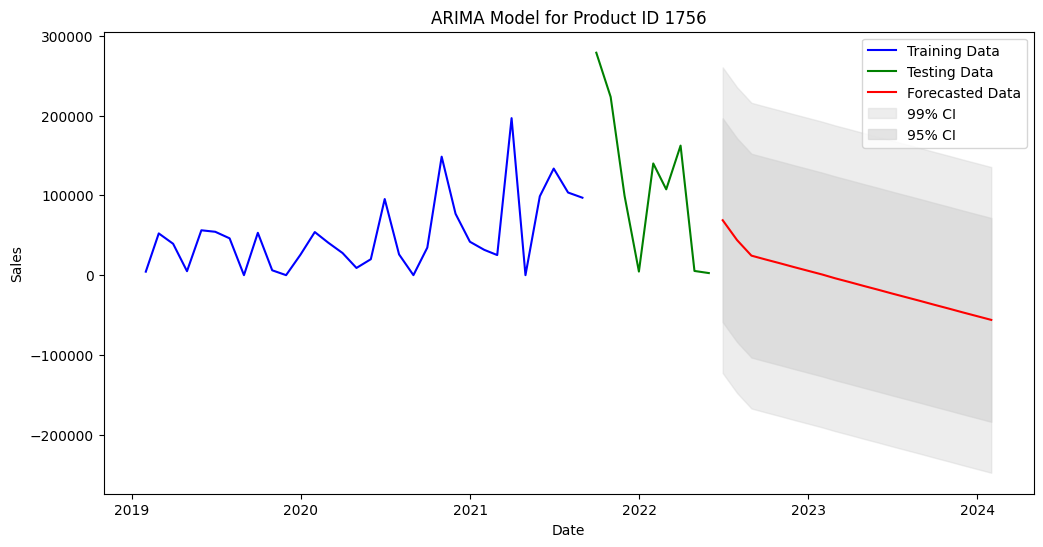

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(train_data_1756['Date'], train_data_1756['Sales'], label='Training Data', color='blue')
plt.plot(test_data_1756['Date'], test_data_1756['Sales'], label='Testing Data', color='green')
plt.plot(forecast_df_1756['Date'], forecast_df_1756['Sales'], label='Forecasted Data', color='red')
plt.fill_between(forecast_df_1756['Date'], forecast_values_1756 + 3 * std_dev_1756, forecast_values_1756 - 3 * std_dev_1756, color='lightgray', alpha=0.4, label='99% CI')
plt.fill_between(forecast_df_1756['Date'], forecast_values_1756 + 2 * std_dev_1756, forecast_values_1756 - 2 * std_dev_1756, color='lightgray', alpha=0.6, label='95% CI')
plt.title('ARIMA Model for Product ID 1756')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

In [ ]:
# for 192 product
product_192 = product_demand[product_demand['ProductID'] == 192].reset_index(drop = True)
product_192.set_index('Date', inplace = True)
product_192.sort_index(inplace = True)
product_192_monthly = product_192.resample('M')['TotalSales'].sum().to_frame().reset_index()
product_192_monthly.rename(columns = {'TotalSales':'Sales'}, inplace = True)
product_192_monthly.head()

,Date,Sales
0,2019-01-31,8457.796611
1,2019-02-28,19805.084745
2,2019-03-31,16021.186442
3,2019-04-30,15835.084745
4,2019-05-31,82297.305097


In [ ]:
product_192_monthly

,Date,Sales
0,2019-01-31,8457.796611
1,2019-02-28,19805.084745
2,2019-03-31,16021.186442
3,2019-04-30,15835.084745
4,2019-05-31,82297.305097
5,2019-06-30,38818.305086
6,2019-07-31,28143.898304
7,2019-08-31,30205.762713
8,2019-09-30,18880.084745
9,2019-10-31,43991.254237


In [ ]:
# Split the data into training and testing sets
train_size = int(len(product_192_monthly) * 0.8)
train_data, test_data = product_192_monthly[:train_size], product_192_monthly[train_size:]

In [ ]:
# Initialize lists to store model results
p = d = q = range(0, 5)
pdq = list(itertools.product(p, d, q))
model_list, AIC_list, BIC_list, MAD_list, MAPE_list, MSE_list, RMSE_list = [], [], [], [], [], [], []

for param in tqdm(pdq):
    try:
        model = ARIMA(train_data['Sales'], order=param)
        results = model.fit()
        model_list.append(f'ARIMA{param}')
        # print(f'ARIMA{param} - AIC: {results.aic:.2f}, BIC: {results.bic:.2f}')
        y_true = test_data['Sales']
        y_pred = results.forecast(steps=len(test_data))

        # Calculate evaluation metrics
        mad = np.mean(np.abs((y_true - y_pred))) * 100
        mse = np.mean(np.abs((y_true - y_pred)))
        rmse = np.sqrt(mse)

        AIC_list.append(results.aic)
        BIC_list.append(results.bic)
        MAD_list.append(mad)
        MSE_list.append(mse)
        RMSE_list.append(rmse)

    except:
        continue

# Create a DataFrame to store the results
df_result = pd.DataFrame({
    'Setting': model_list,
    'AIC': AIC_list,
    'BIC': BIC_list,
    'MAD': MAD_list,
    'MSE': MSE_list,
    'RMSE': RMSE_list
})

  0%|          | 0/125 [00:00<?, ?it/s]

In [ ]:
print(f'Best ARIMA model due to least AIC value: {df_result["Setting"][np.argmin(df_result["AIC"])]}')
print(f'Best ARIMA model due to least BIC value: {df_result["Setting"][np.argmin(df_result["BIC"])]}')
print(f'Best ARIMA model due to least MAD value: {df_result["Setting"][np.argmin(df_result["MAD"])]}')
print(f'Best ARIMA model due to least MSE value: {df_result["Setting"][np.argmin(df_result["MSE"])]}')
print(f'Best ARIMA model due to least RMSE value: {df_result["Setting"][np.argmin(df_result["RMSE"])]}')

Best ARIMA model due to least AIC value: ARIMA(4, 4, 4)
Best ARIMA model due to least BIC value: ARIMA(4, 4, 4)
Best ARIMA model due to least MAD value: ARIMA(3, 1, 1)
Best ARIMA model due to least MSE value: ARIMA(3, 1, 1)
Best ARIMA model due to least RMSE value: ARIMA(3, 1, 1)


In [ ]:
# Plot the training, testing, and forecasted data
model = ARIMA(product_192_monthly['Sales'], order = (3, 1, 1))
results = model.fit()
residuals = results.resid
std_dev = np.std(residuals)

n_months = 20
forecast_values = results.forecast(steps = n_months)
forecast_df = pd.DataFrame({
    'Date':pd.date_range((test_data['Date'].iloc[-1]+ pd.DateOffset(months = 1)).strftime("%Y-%m-%d"),
                         (test_data['Date'].iloc[-1]+ pd.DateOffset(months = n_months)).strftime("%Y-%m-%d"), freq = 'M'),
    'Sales':forecast_values
})
forecast_df


,Date,Sales
41,2022-06-30,44810.057479
42,2022-07-31,71516.929888
43,2022-08-31,79059.004469
44,2022-09-30,58660.378545
45,2022-10-31,62644.387427
46,2022-11-30,67960.519977
47,2022-12-31,61582.636318
48,2023-01-31,61014.300069
49,2023-02-28,63294.256321
50,2023-03-31,61595.615142


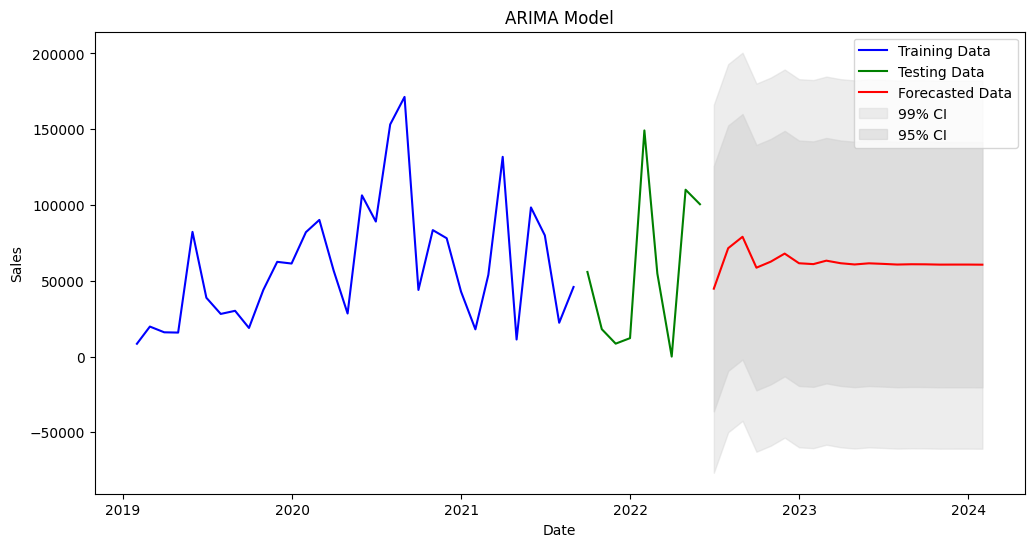

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(train_data['Date'], train_data['Sales'], label='Training Data', color='blue')
plt.plot(test_data['Date'], test_data['Sales'], label='Testing Data', color='green')
plt.plot(forecast_df['Date'], forecast_df['Sales'], label='Forecasted Data', color='red')
plt.fill_between(forecast_df['Date'], forecast_values + 3 * std_dev, forecast_values - 3 * std_dev, color='lightgray', alpha=0.4, label='99% CI')
plt.fill_between(forecast_df['Date'], forecast_values + 2 * std_dev, forecast_values - 2 * std_dev, color='lightgray', alpha=0.6, label='95% CI')
plt.title('ARIMA Model')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

In [ ]:
#for 543 product
product_543 = product_demand[product_demand['ProductID'] == 543].reset_index(drop=True)
product_543.set_index('Date', inplace=True)
product_543.sort_index(inplace=True)
product_543_monthly = product_543.resample('M')['TotalSales'].sum().to_frame().reset_index()
product_543_monthly.rename(columns={'TotalSales': 'Sales'}, inplace=True)
product_543_monthly.head()

,Date,Sales
0,2019-03-31,19839.999998
1,2019-04-30,135.593220
2,2019-05-31,919.491525
3,2019-06-30,44260.084744
4,2019-07-31,12364.406780


In [ ]:
# Split the data into training and testing sets
train_size_543 = int(len(product_543_monthly) * 0.8)
train_data_543, test_data_543 = product_543_monthly[:train_size_543], product_543_monthly[train_size_543:]

In [ ]:
# Initialize lists to store model results
p = d = q = range(0, 5)
pdq = list(itertools.product(p, d, q))
model_list_543, AIC_list_543, BIC_list_543, MAD_list_543, MAPE_list_543, MSE_list_543, RMSE_list_543 = [], [], [], [], [], [], []

for param in tqdm(pdq):
    try:
        model_543 = ARIMA(train_data_543['Sales'], order=param)
        results_543 = model_543.fit()
        model_list_543.append(f'ARIMA{param}')
        # print(f'ARIMA{param} - AIC: {results_543.aic:.2f}, BIC: {results_543.bic:.2f}')
        y_true_543 = test_data_543['Sales']
        y_pred_543 = results_543.forecast(steps=len(test_data_543))

        # Calculate evaluation metrics
        mad_543 = np.mean(np.abs((y_true_543 - y_pred_543))) * 100
        mse_543 = np.mean(np.abs((y_true_543 - y_pred_543)))
        rmse_543 = np.sqrt(mse_543)

        AIC_list_543.append(results_543.aic)
        BIC_list_543.append(results_543.bic)
        MAD_list_543.append(mad_543)
        MSE_list_543.append(mse_543)
        RMSE_list_543.append(rmse_543)

    except:
        continue

# Create a DataFrame to store the results
df_result_543 = pd.DataFrame({
    'Setting': model_list_543,
    'AIC': AIC_list_543,
    'BIC': BIC_list_543,
    'MAD': MAD_list_543,
    'MSE': MSE_list_543,
    'RMSE': RMSE_list_543
})

  0%|          | 0/125 [00:00<?, ?it/s]

In [ ]:
print(f'Best ARIMA model due to least AIC value: {df_result_543["Setting"][np.argmin(df_result_543["AIC"])]}')
print(f'Best ARIMA model due to least BIC value: {df_result_543["Setting"][np.argmin(df_result_543["BIC"])]}')
print(f'Best ARIMA model due to least MAD value: {df_result_543["Setting"][np.argmin(df_result_543["MAD"])]}')
print(f'Best ARIMA model due to least MSE value: {df_result_543["Setting"][np.argmin(df_result_543["MSE"])]}')
print(f'Best ARIMA model due to least RMSE value: {df_result_543["Setting"][np.argmin(df_result_543["RMSE"])]}')

Best ARIMA model due to least AIC value: ARIMA(1, 4, 4)
Best ARIMA model due to least BIC value: ARIMA(0, 4, 4)
Best ARIMA model due to least MAD value: ARIMA(2, 2, 3)
Best ARIMA model due to least MSE value: ARIMA(2, 2, 3)
Best ARIMA model due to least RMSE value: ARIMA(2, 2, 3)


In [ ]:
# Plot the training, testing, and forecasted data
model_543 = ARIMA(product_543_monthly['Sales'], order=(2,2,3))
results_543 = model_543.fit()
residuals_543 = results_543.resid
std_dev_543 = np.std(residuals_543)

n_months = 20
forecast_values_543 = results_543.forecast(steps=n_months)
forecast_df_543 = pd.DataFrame({
    'Date': pd.date_range((test_data_543['Date'].iloc[-1] + pd.DateOffset(months=1)).strftime("%Y-%m-%d"),
                         (test_data_543['Date'].iloc[-1] + pd.DateOffset(months=n_months)).strftime("%Y-%m-%d"), freq='M'),
    'Sales': forecast_values_543
})

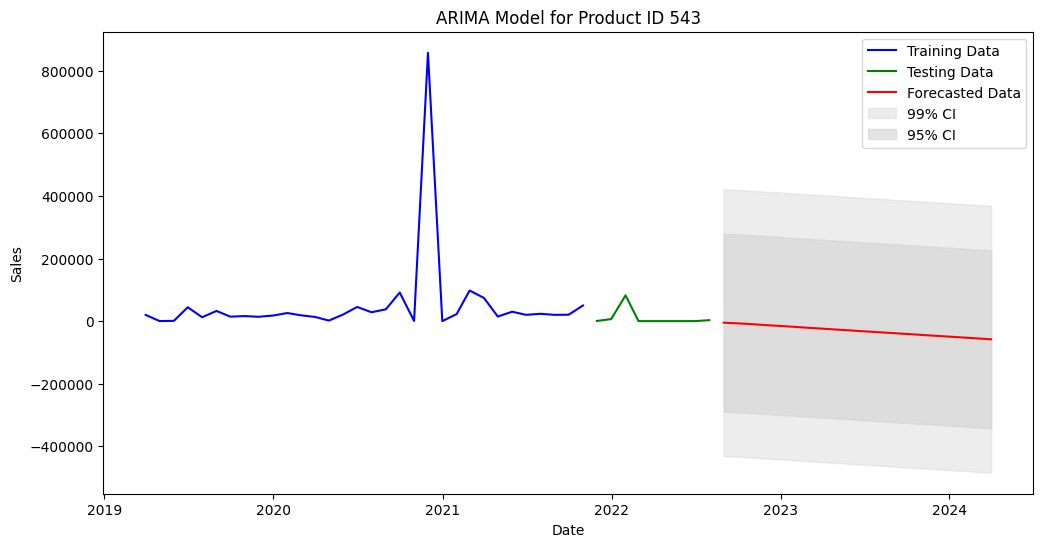

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(train_data_543['Date'], train_data_543['Sales'], label='Training Data', color='blue')
plt.plot(test_data_543['Date'], test_data_543['Sales'], label='Testing Data', color='green')
plt.plot(forecast_df_543['Date'], forecast_df_543['Sales'], label='Forecasted Data', color='red')
plt.fill_between(forecast_df_543['Date'], forecast_values_543 + 3 * std_dev_543, forecast_values_543 - 3 * std_dev_543, color='lightgray', alpha=0.4, label='99% CI')
plt.fill_between(forecast_df_543['Date'], forecast_values_543 + 2 * std_dev_543, forecast_values_543 - 2 * std_dev_543, color='lightgray', alpha=0.6, label='95% CI')
plt.title('ARIMA Model for Product ID 543')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

In [ ]:
forecast_values_543

41    -5050.897659
42    -7020.619679
43    -9637.619283
44   -12693.338604
45   -15449.220806
46   -18300.480630
47   -21141.328004
48   -23975.523865
49   -26814.340079
50   -29651.673021
51   -32489.173187
52   -35326.774148
53   -38164.303920
54   -41001.856756
55   -43839.406910
56   -46676.955537
57   -49514.505262
58   -52352.054628
59   -55189.604036
60   -58027.153468
Name: predicted_mean, dtype: float64

In [ ]:
#for 885 product
product_885 = product_demand[product_demand['ProductID'] == 885].reset_index(drop=True)
product_885.set_index('Date', inplace=True)
product_885.sort_index(inplace=True)
product_885_monthly = product_885.resample('M')['TotalSales'].sum().to_frame().reset_index()
product_885_monthly.rename(columns={'TotalSales': 'Sales'}, inplace=True)
product_885_monthly.head()

,Date,Sales
0,2019-01-31,10510.508475
1,2019-02-28,796.610169
2,2019-03-31,0.000000
3,2019-04-30,0.000000
4,2019-05-31,0.000000


In [ ]:
# Split the data into training and testing sets
train_size_885 = int(len(product_885_monthly) * 0.8)
train_data_885, test_data_885 = product_885_monthly[:train_size_885], product_885_monthly[train_size_885:]

In [ ]:
# Initialize lists to store model results
p = d = q = range(0, 5)
pdq = list(itertools.product(p, d, q))
model_list_885, AIC_list_885, BIC_list_885, MAD_list_885, MAPE_list_885, MSE_list_885, RMSE_list_885 = [], [], [], [], [], [], []

for param in tqdm(pdq):
    try:
        model_885 = ARIMA(train_data_885['Sales'], order=param)
        results_885 = model_885.fit()
        model_list_885.append(f'ARIMA{param}')
        # print(f'ARIMA{param} - AIC: {results.aic:.2f}, BIC: {results.bic:.2f}')
        y_true_885 = test_data_885['Sales']
        y_pred_885 = results_885.forecast(steps=len(test_data_885))

        # Calculate evaluation metrics
        mad_885 = np.mean(np.abs((y_true_885 - y_pred_885))) * 100
        mse_885 = np.mean(np.abs((y_true_885 - y_pred_885)))
        rmse_885 = np.sqrt(mse_885)

        AIC_list_885.append(results_885.aic)
        BIC_list_885.append(results_885.bic)
        MAD_list_885.append(mad_885)
        MSE_list_885.append(mse_885)
        RMSE_list_885.append(rmse_885)

    except:
        continue

# Create a DataFrame to store the results
df_result_885 = pd.DataFrame({
    'Setting': model_list,
    'AIC': AIC_list_885,
    'BIC': BIC_list_885,
    'MAD': MAD_list_885,
    'MSE': MSE_list_885,
    'RMSE': RMSE_list_885
})

  0%|          | 0/125 [00:00<?, ?it/s]

In [ ]:
print(f'Best ARIMA model due to least AIC value: {df_result_885["Setting"][np.argmin(df_result_885["AIC"])]}')
print(f'Best ARIMA model due to least BIC value: {df_result_885["Setting"][np.argmin(df_result_885["BIC"])]}')
print(f'Best ARIMA model due to least MAD value: {df_result_885["Setting"][np.argmin(df_result_885["MAD"])]}')
print(f'Best ARIMA model due to least MSE value: {df_result_885["Setting"][np.argmin(df_result_885["MSE"])]}')
print(f'Best ARIMA model due to least RMSE value: {df_result_885["Setting"][np.argmin(df_result_885["RMSE"])]}')

Best ARIMA model due to least AIC value: ARIMA(2, 4, 2)
Best ARIMA model due to least BIC value: ARIMA(2, 4, 2)
Best ARIMA model due to least MAD value: ARIMA(0, 1, 0)
Best ARIMA model due to least MSE value: ARIMA(0, 1, 0)
Best ARIMA model due to least RMSE value: ARIMA(0, 1, 0)


In [ ]:
# Plot the training, testing, and forecasted data
model_885 = ARIMA(product_885_monthly['Sales'], order=(0, 1, 0))
results_885 = model_885.fit()
residuals_885 = results_885.resid
std_dev_885 = np.std(residuals_885)

n_months = 20
forecast_values_885 = results_885.forecast(steps=n_months)
forecast_df_885 = pd.DataFrame({
    'Date': pd.date_range((test_data_885['Date'].iloc[-1] + pd.DateOffset(months=1)).strftime("%Y-%m-%d"),
                         (test_data_885['Date'].iloc[-1] + pd.DateOffset(months=n_months)).strftime("%Y-%m-%d"), freq='M'),
    'Sales': forecast_values_885
})
forecast_values_885

51    36794.025422
52    36794.025422
53    36794.025422
54    36794.025422
55    36794.025422
56    36794.025422
57    36794.025422
58    36794.025422
59    36794.025422
60    36794.025422
61    36794.025422
62    36794.025422
63    36794.025422
64    36794.025422
65    36794.025422
66    36794.025422
67    36794.025422
68    36794.025422
69    36794.025422
70    36794.025422
Name: predicted_mean, dtype: float64

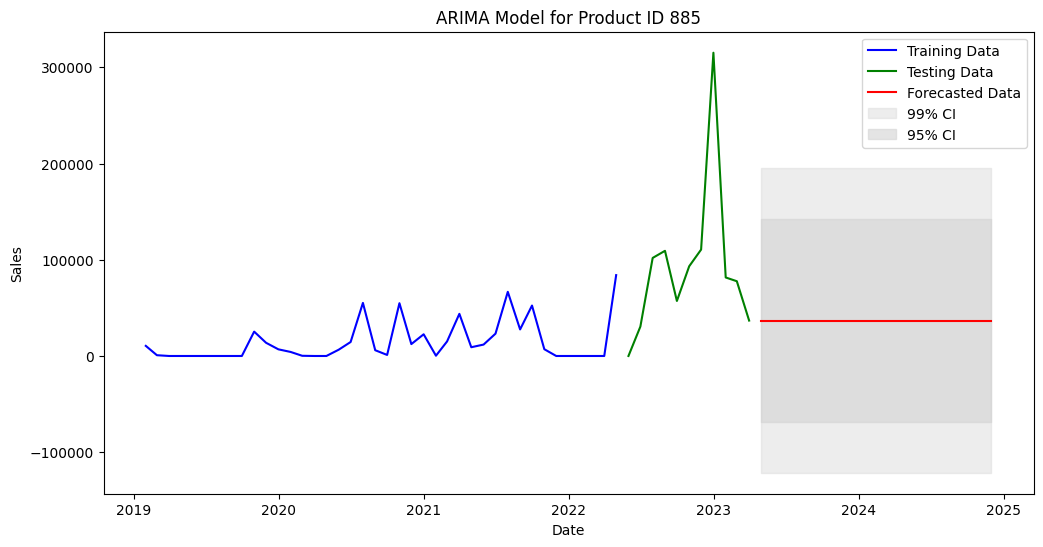

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(train_data_885['Date'], train_data_885['Sales'], label='Training Data', color='blue')
plt.plot(test_data_885['Date'], test_data_885['Sales'], label='Testing Data', color='green')
plt.plot(forecast_df_885['Date'], forecast_df_885['Sales'], label='Forecasted Data', color='red')
plt.fill_between(forecast_df_885['Date'], forecast_values_885 + 3 * std_dev_885, forecast_values_885 - 3 * std_dev_885, color='lightgray', alpha=0.4, label='99% CI')
plt.fill_between(forecast_df_885['Date'], forecast_values_885 + 2 * std_dev_885, forecast_values_885 - 2 * std_dev_885, color='lightgray', alpha=0.6, label='95% CI')
plt.title('ARIMA Model for Product ID 885')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

> SARIMA

In [ ]:
# # Split your data into training and testing sets
# train_size = int(len(sales_data) * 0.8)  # Adjust the split ratio as needed
# train_data, test_data = sales_data[:train_size], sales_data[train_size:]

# # Initialize lists to store model results
# p = d = q = range(0, 5)
# pdq = list(itertools.product(p, d, q))
# seasonal_pdq = [(x[0], x[1], x[2], 6) for x in list(itertools.product(p, d, q))]
# model_list, AIC_list, BIC_list, MAD_list, MAPE_list, MSE_list, RMSE_list = [], [], [], [], [], [], []

# for param in tqdm(pdq):
#     for param_seasonal in seasonal_pdq:
#         try:
#             model = SARIMAX(train_data['Sales'], order = param, seasonal_order = param_seasonal)
#             results = model.fit()
#             model_list.append(f'SARIMA{param}{param_seasonal}')
#             y_true = test_data['Sales']
#             y_pred = results.forecast(steps=len(test_data))

#             # Calculate evaluation metrics
#             mad = np.mean(np.abs((y_true - y_pred))) * 100
#             mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
#             mse = np.mean(np.abs((y_true - y_pred)))
#             rmse = np.sqrt(mse)

#             AIC_list.append(results.aic)
#             BIC_list.append(results.bic)
#             MAD_list.append(mad)
#             MAPE_list.append(mape)
#             MSE_list.append(mse)
#             RMSE_list.append(rmse)

#         except:
#             continue

# # Create a DataFrame to store the results
# df_result = pd.DataFrame({
#     'Setting': model_list,
#     'AIC': AIC_list,
#     'BIC': BIC_list,
#     'MAD': MAD_list,
#     'MAPE': MAPE_list,
#     'MSE': MSE_list,
#     'RMSE': RMSE_list
# })


In [ ]:
# print(f'Best SARIMA model due to least AIC value: {df_result["Setting"][np.argmin(df_result["AIC"])]}')
# print(f'Best SARIMA model due to least BIC value: {df_result["Setting"][np.argmin(df_result["BIC"])]}')
# print(f'Best SARIMA model due to least MAD value: {df_result["Setting"][np.argmin(df_result["MAD"])]}')
# print(f'Best SARIMA model due to least MSE value: {df_result["Setting"][np.argmin(df_result["MSE"])]}')
# print(f'Best SARIMA model due to least RMSE value: {df_result["Setting"][np.argmin(df_result["RMSE"])]}')
# print(f'Best SARIMA model due to least MAPE value: {df_result["Setting"][np.argmin(df_result["MAPE"])]}')

In [ ]:

# # Plot the training, testing, and forecasted data with 2 sigma boundaries
# best_order = (1, 1, 1)
# best_seasonal_order = (1, 1, 1, 7)

# model = SARIMAX(sales_data['Sales'], order = best_order, seasonal_order = best_seasonal_order)
# results = model.fit()
# residuals = results.resid
# std_dev = np.std(residuals)

# n_days = 365
# forecast_values = results.forecast(steps=n_days)
# forecast_df = pd.DataFrame({
#     'Date': pd.date_range((test_data['Date'].iloc[-1] + pd.DateOffset(1)).strftime("%Y-%m-%d"),
#                           (test_data['Date'].iloc[-1] + pd.DateOffset(n_days)).strftime("%Y-%m-%d")),
#     'Sales': forecast_values
# })
# plt.figure(figsize=(12, 6))
# plt.plot(train_data['Date'], train_data['Sales'], label='Training Data', color='blue')
# plt.plot(test_data['Date'], test_data['Sales'], label='Testing Data', color='green')
# plt.plot(forecast_df['Date'], forecast_df['Sales'], label='Forecasted Data', color='red')
# plt.fill_between(forecast_df['Date'], forecast_values + 3 * std_dev, forecast_values - 3 * std_dev, color='lightgray', alpha=0.4, label='99% CI')
# plt.fill_between(forecast_df['Date'], forecast_values + 2 * std_dev, forecast_values - 2 * std_dev, color='lightgray', alpha=0.6, label='95% CI')
# plt.title('SARIMA Model Forecast with 2 Sigma Boundary')
# plt.xlabel('Date')
# plt.ylabel('Sales')
# plt.legend()
# plt.show()

> Advanced Model